## Package 설치


> 먼저 본 실습에 필요한 transformers 와 pytorch-lightning 을 설치합니다.

In [1]:
!pip install transformers==4.6.0
!pip install pytorch-lightning==1.3.1

     |████████████████████████████████| 2.3MB 28.2MB/s 
     |████████████████████████████████| 3.3MB 42.6MB/s 
     |████████████████████████████████| 901kB 40.8MB/s 
     |████████████████████████████████| 808kB 31.7MB/s 
     |████████████████████████████████| 276kB 42.8MB/s 
     |████████████████████████████████| 645kB 51.5MB/s 
     |████████████████████████████████| 112kB 44.3MB/s 
     |████████████████████████████████| 829kB 45.8MB/s 
     |████████████████████████████████| 1.3MB 50.0MB/s 
     |████████████████████████████████| 296kB 54.1MB/s 
     |████████████████████████████████| 143kB 56.8MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=fc80c425b4895776dc4fed0cee4cb7dc75b586fe341fb136c6702d4e5a7f4bca
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninst

## 데이터 다운로드


> 다음은 본 실습에서 필요한 데이터 셋을 다운로드 받아 주세요.



In [2]:
!git clone https://github.com/e9t/nsmc

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.55 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [3]:
!ls -l nsmc/

total 38620
drwxr-xr-x 2 root root     4096 May 18 08:09 code
-rw-r--r-- 1 root root  4893335 May 18 08:09 ratings_test.txt
-rw-r--r-- 1 root root 14628807 May 18 08:09 ratings_train.txt
-rw-r--r-- 1 root root 19515078 May 18 08:09 ratings.txt
drwxr-xr-x 2 root root   454656 May 18 08:09 raw
-rw-r--r-- 1 root root     2596 May 18 08:09 README.md
-rw-r--r-- 1 root root    36746 May 18 08:09 synopses.json


## Google Drive 연동 하기

> 학습이 끝나고 모델을 Google Drive에 저장 하기 위해 colab과 google drive를 연동 합니다.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Torch Dataset

> 다운로드 받은 nsmc 데이터로부터 학습 데이터를 만들기 위해 Pytorch Dataset을 만들어 줍니다. 전처리는 가장 기본 적인 전처리 과정만 하였습니다.



In [5]:
import pandas as pd
import torch

from torch.utils.data import Dataset


class NSMCDataset(Dataset):
    def __init__(self, csv_file, tokenizer):
        df = pd.read_csv(csv_file, sep='\t')
        # NaN 값 제거
        df = df.dropna(axis=0)
        # 중복 제거
        df.drop_duplicates(subset=['document'], inplace=True)
        self.input_ids = tokenizer.batch_encode_plus(
            df['document'].to_list(),
            return_tensors='pt',
            truncation=True,
            padding='longest',
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=False,
        )['input_ids']
        self.labels = torch.LongTensor(df['label'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

## Pytorch Lightning Model


> KoBERT를 기반으로 분류모델을 만들어 줍니다. KoBERT는 huggingface 에 있는 모델 중 [KcBERT](https://github.com/Beomi/KcBERT)를 사용 하였습니다.



In [6]:
import torch

from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score


class KoBERT(LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.bert = BertForSequenceClassification.from_pretrained(self.hparams.model_path)
        self.tokenizer = BertTokenizerFast.from_pretrained(self.hparams.model_path)

    def forward(self, **kwargs):
        return self.bert(**kwargs)

    def step(self, batch, batch_idx):
        data, labels = batch
        output = self(input_ids=data, labels=labels)

        loss = output.loss

        y_true = labels.tolist()
        y_pred = output.logits.argmax(dim=-1).tolist()

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred,
        }

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def epoch_end(self, outputs, state):
        loss = torch.tensor(0, dtype=torch.float)
        y_true = []
        y_pred = []
        for output in outputs:
            loss += output['loss'].cpu().detach()
            y_true.extend(output['y_true'])
            y_pred.extend(output['y_pred'])
        loss = loss / len(outputs)

        self.log(state + '_loss', float(loss), on_epoch=True, prog_bar=True)
        self.log(state + '_acc', accuracy_score(y_true, y_pred), on_epoch=True, prog_bar=True)

    def training_epoch_end(self, outputs):
        return self.epoch_end(outputs, state='train')

    def validation_epoch_end(self, outputs):
        return self.epoch_end(outputs, state='val')

    def configure_optimizers(self):
        optimizer = AdamW(self.bert.parameters(), lr=self.hparams.lr)

        num_train_steps = len(self.train_dataloader()) * self.hparams.max_epochs
        num_warmup_steps = int(num_train_steps * self.hparams.warmup_ratio)

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_train_steps
        )

        lr_scheduler = {
            'scheduler': scheduler,
            'interval': 'step',
            'frequency': 1
        }

        return [optimizer], [lr_scheduler]

    def dataloader(self, file_path, shuffle) -> DataLoader:
        dataset = NSMCDataset(file_path, self.tokenizer)
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=shuffle,
            pin_memory=True,
        )

    def train_dataloader(self) -> DataLoader:
        return self.dataloader(self.hparams.train_data_path, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return self.dataloader(self.hparams.val_data_path, shuffle=False)

    def save_hugginface(self):
        self.bert.save_pretrained(self.hparams.save_path)

## 학습


> 모델을 학습합니다. 학습에 사용할 파라메터는 `args`에서 정의 하였습니다.



In [7]:
args = {
    'train_data_path': './nsmc/ratings_train.txt',
    'val_data_path': './nsmc/ratings_test.txt',
    'save_path': '/content/gdrive/MyDrive/huggingface_model',
    'max_epochs': 3,
    'model_path': 'beomi/kcbert-base',
    'batch_size': 32,
    'num_workers': 2,
    'lr': 5e-6,
    'warmup_ratio': 0.0,
    'fp16': True,
}

In [8]:
model = KoBERT(**args)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [9]:
from pytorch_lightning import Trainer


trainer = Trainer(
    max_epochs=args['max_epochs'],
    num_sanity_val_steps=0,
    deterministic=torch.cuda.is_available(),
    gpus=-1 if torch.cuda.is_available() else None,
    precision=16 if args['fp16'] else 32,
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 108 M 
-------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.680   Total estimated model params size (MB)


## Smaple Data 넣어 보기



> 학습한 모델에 몇가지 데이터를 넣어서 확인해보겠습니다.

In [10]:
# 평점 10
pos_text = '이방원을 다룬 드라마중 최고였다고 자부함. 진짜 이방원을 보여준 듯이 연기와 인물묘사나 주변상황이 재밌었고 스토리도 진부하지 않았음. 다시 이런드라마를 볼수 있을지~ 진짜 이런 드라마하나 또 나왔음 함.'
# 평점 0
neg_text = '핵노잼 후기보고 낙였네 방금보고왔는데 개실망 재미없어요'

In [11]:
pos_input_vector = model.tokenizer.encode(pos_text, return_tensors='pt')
neg_input_vector = model.tokenizer.encode(neg_text, return_tensors='pt')

In [12]:
pos_pred = model(input_ids=pos_input_vector, labels=None).logits.argmax(dim=-1).tolist()
neg_pred = model(input_ids=neg_input_vector, labels=None).logits.argmax(dim=-1).tolist()

In [13]:
print(f'{pos_text} : {pos_pred[0]}')
print(f'{neg_text} : {neg_pred[0]}')

이방원을 다룬 드라마중 최고였다고 자부함. 진짜 이방원을 보여준 듯이 연기와 인물묘사나 주변상황이 재밌었고 스토리도 진부하지 않았음. 다시 이런드라마를 볼수 있을지~ 진짜 이런 드라마하나 또 나왔음 함. : 1
핵노잼 후기보고 낙였네 방금보고왔는데 개실망 재미없어요 : 0


In [14]:
# 허깅페이스 모델에 맞게 저장 합니다.
model.save_hugginface()  

## 구글 드라이브에 저장된 모델 확인

> 모델을 저장 했으면 아래와 같이 자신이 설정한 곳으로 저장이 되어 있을 것 입니다. 현재는 간단하게 구글 드라이브에 저장을 했지만, 실제로 MLOps Pipeline 을 만들게 되면 다르게 저장해야 할 것 입니다.


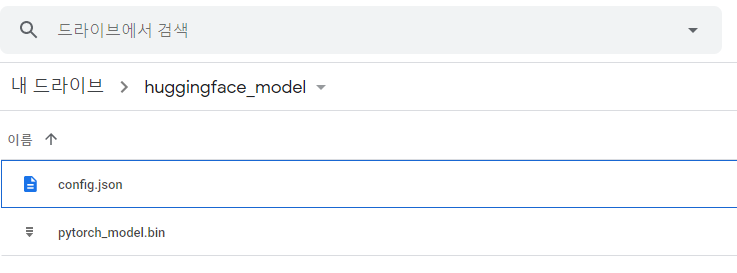

## 파라메터 튜닝 하기

> 해당 코드에서는 별도의 최적화를 하지 않았습니다. 이제 다양한 방법으로 최적화를 진행하며 여러분의 목적에 맞는 파라메터를 찾아 보세요. 추천 드리는 파라메터는 아래와 같습니다.

* 모델 : beomi/kcbert-base, beomi/kcbert-large...
* 학습률(Learning Rate) : 5e-5, 1e-5, 5e-6, 1e-6...
* 전처리 : nlpretext, soynlp...


